## Plot puv fluxes (baroclinic and barotropic energy)
* Adapted from plot_BclinNRJ_subdom
* Plot snapshots of, e.g. low-pass filtered fields or avg.
* Store values per subdomain in a json file
* Not for animation, so I load every fields
* Adapted for time variable internal tide field
* compute mean of summer and winter at the end of the notebook

**WARNING** there might be some errors, e.g. with time indices

In [87]:
%matplotlib notebook
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
#plt.rcParams['text.usetex'] = True
from mpl_toolkits.basemap import Basemap

from netCDF4 import Dataset, MFDataset
import sys, os
import numpy as np
import gsw
from scipy.ndimage import gaussian_filter
from PIL import Image, ImageDraw
import json
from collections import OrderedDict
import pandas as pd

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = "/net/ruchba/local/tmp/2/lahaye/"
HOME = os.getenv('HOME')+"/"

In [88]:
simul = 'luckyt'
what = "ekint"
dostrflu = False # stream plot of baroclinic flux
dosqflu = True # quiver (by-passed by dostrflu if the latter is True)
if simul in ['luckyt']:
    suff = "_win"
else:
    suff = ""
    
path_base = KRYPTON + 'DIAG/NRJ_fluxes/'
fil_iflux = path_base+simul+'_bclnrj{}.?.nc'.format(suff)#'_bclnrj_M2.?.nc'
fil_sflux = path_base+simul+'_btrnrj{}.?.nc'.format(suff)#'_bt_fluxes.?.nc'
fil_linth = KRYPTON+"Tide_Conv/output_data/cterm_M2_linear_theory_Ny05.nc"
fil_grd = KRYPTON + 'lucky_corgrd.nc'
pdatout = HOME+"working_on/NRJ_flux_diag/{}_NRJ_diags".format(simul+suff)

st = 2  #ncr.subsamp_step
pm, pn = (1/(st*750),)*2 # a la main but should be read in file for more generality

units = {"ekint":r"kJ/m$^2$", "flux":r"kw/m", "cterm":r"mW/m$^2$", "ctavg":r"mW/m$^2$",
        "divf":r"mW/m$^2$", "diss":r"mW/m$^2$", "etot":r"kJ/m$^2$",  "dfav":r"mW/m$^2$", "diav":r"mW/m$^2$"}
vnam = {key:key for key in ["ekint", "ekavg", "flux", "cterm", "divf", "diss"]}
vnam["cterm"] = r"$C_t$"
vnam["ekint"] = r"$E_k$"
vnam["etot"] = r"$E$"

#plotting parameters
dirpic = './pictures/subdom_diags/'#paper/'
dosavefig = True

# plotting parameters
fs       = 12
proj     = 'lcc'
brs      = 'i'
stride   = 5
Lx,Ly    = 1500e3, 1490e3 #2*2*30*1852*np.array([1,1]) # extend in m
cmap = plt.get_cmap('gist_stern_r')  #
zlevs = [0,1000,2000,3500]
topocol = 'k'     # isobath. contour color
grdcol = 'gray'   # grid color

xm, ym = None, None #-32.28, 37.3

rlevs = None

In [96]:
# Load data: grid & topo & subdomains
doploth = True  # plot topo 

ncg = Dataset(fil_grd,'r')
slix = slice(1,2000,st)
sliy = slice(1,2000,st)
lon = ncg.variables['lon_rho'][sliy,:][:,slix]
lat = ncg.variables['lat_rho'][sliy,:][:,slix]
dx = .5*(np.mean(1./ncg.variables['pm'][:]) + np.mean(1./ncg.variables['pn'][:]) ) * st
Ny, Nx = lon.shape
if xm is not None:
    jm, im = np.unravel_index( ((lon-xm)**2 + (lat-ym)**2).argmin(), (Ny,Nx) )
    j1, j2 = jm + np.array([-1,1])*int(Lx/dx/2.)
    i1, i2 = im + np.array([-1,1])*int(Ly/dx/2.)
    print("jjs, iis:",j1,j2,i1,i2, "from parent: X",st)
else:
    j1, j2, i1, i2 = 0, Ny, 0, Nx
topo = ncg.variables['h'][sliy,:][:,slix][j1:j2,i1:i2]
lon = lon[j1:j2,i1:i2]
lat = lat[j1:j2,i1:i2]
print("loaded grid")

# load subdomains
with open("subdomains_lucky.json", "r") as fp:
    prov = json.load(fp)
mydoms = OrderedDict()
for key in ["seamounts","ridges","islands","plain"]:
    mydoms[key] = prov[key]

print("min/max lon, lat:", lon.min(), lon.max(), lat.min(), lat.max())

# Unfold subdomains
doms, nams = [], []
for key,val in mydoms.items():
    if key == "ridges":
        for ido,dom in enumerate(val):
            doms.append(dom)
            nams.append(key.rstrip("s")+str(ido+1))
    else:
        doms.append(val)
        nams.append(key)
        
# local routines
def coord_to_pix(pos, lon=lon, lat=lat):
    return np.unravel_index(((lon-pos[0])**2+(lat-pos[1])**2).argmin(), lon.shape)[::-1]

def poly_to_mask(poly,shape):
    img = Image.new('1',shape)
    ImageDraw.Draw(img).polygon(poly, outline=1, fill=1)
    return np.array(img)

def polycoord_tomask(coord,lon,lat):
    poly = [coord_to_pix(item,lon,lat) for item in coord]
    return poly_to_mask(poly,lon.shape)

def get_domean(field, dom, lon=lon, lat=lat, masksup=(topo>100)):
    mask = polycoord_tomask(dom, lon, lat)
    if masksup is not None: mask *= masksup
    return np.nanmean(field[...,mask], axis=(-1))

# load or create dataframe
if os.path.isfile(pdatout+".pkl"):
    datfra = pd.read_pickle(pdatout+".pkl")
    print("loaded dataframe from pickle")
elif os.path.isfile(pdatout+".csv"):
    datfra = pd.read_csv(pdatout+".csv", header=[0,1], index_col=0)
    print("loaded dataframe from pickle")
else:
    datfra = pd.DataFrame(index=['full']+nams, \
                          columns=['dKE','dPE','hdiff','vmix','drag'])
    print("created dataframe")

loaded grid
min/max lon, lat: -41.8086236619 -23.2006244309 30.4960379447 44.2189371832
created dataframe


<IPython.core.display.Javascript object>


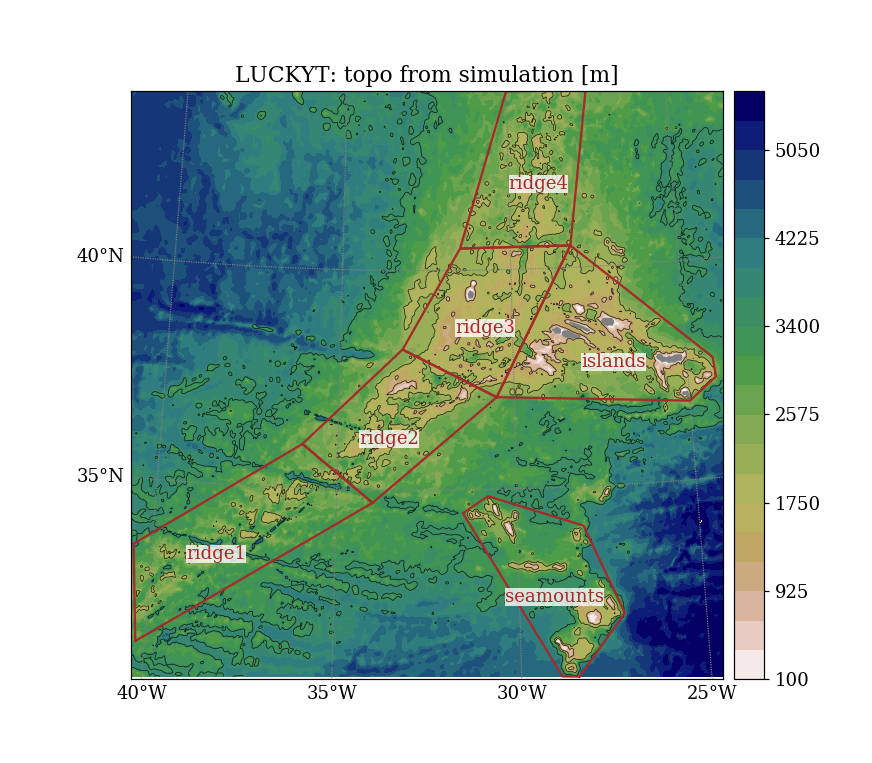

In [12]:
# plot it
do_subdom = True

vmin, vmax = round(topo.min()+50,-2), round(topo.max()-50,-2)
levs = np.linspace(vmin, vmax, 21)
fig = plt.figure(figsize=(8,7))
ax = plt.gca()
bm = Basemap(projection=proj,resolution=brs,lon_0=lon.mean(),\
        lat_0=lat.mean(),width=Lx,height=Ly)
xx, yy = bm(lon, lat)
bm.drawcoastlines(color='gray')
bm.fillcontinents(color='gray')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)
hct = bm.contourf(xx, yy, topo, levels=levs, cmap="gist_earth_r")
hcb = bm.colorbar(hct)
for item in hct.collections:
    item.set_rasterized(True)
hct = bm.contour(xx, yy, topo, levels=zlevs, colors=topocol, linewidths=0.5, alpha=0.8)
for item in hct.collections:
    item.set_rasterized(True)

if do_subdom:
    for key,val in mydoms.items():
        if key == "ridges":
            for ido,dom in enumerate(val):
                x, y = bm(*np.array(dom).T.take(range(len(dom)+1),axis=1,mode='wrap'))
                bm.plot(x, y, color="brown")
                ax.text(x.mean(), y.mean(), key.rstrip('s')+str(ido+1), color="brown", ha="center", va="center", 
                    bbox=dict(facecolor="white", alpha=.8, edgecolor="none", pad=.02))

        else:
            x, y = bm(*np.array(val).T.take(range(len(val)+1),axis=1,mode='wrap'))
            bm.plot(x, y, color="brown")
            ax.text(x.mean(), y.mean(), key, color="brown", ha="center", va="center", 
                    bbox=dict(facecolor="white", alpha=.8, edgecolor="none", pad=.02))

plt.title(simul.upper()+": topo from simulation [m]")

if False:#dosavefig:
    fig.savefig(dirpic+simul+"_topo.pdf", magnification="auto", bboxçinches="tight", dpi=150)

In [90]:
suf = "_lf"
it = 200 #182 #436 #182 #    
tint = None #[900, 1019] # put None to take avg as avg // time index

ncbc = Dataset(fil_iflux.replace('?','0'), "r")
times = ncbc.variables['time'][:]
otime = ncbc.variables['scrum_time'][:]
Nt = len(times)
if tint is not None:
    indt, = np.where((times>=tint[0]) & (times<=tint[1]))
else:
    indt = None
    
def get_varavg(nc, var, indt=None, coords=[i1,i2,j1,j2]):
    i1, i2, j1, j2 = coords
    if indt is None:
        return nc.variables[var+"_avg"][j1:j2,...][:,i1:i2,...]
    else:
        return nc.variables[var+"_lf"][j1:j2,...][:,i1:i2,indt].mean(axis=-1)

# load data
print("loading", end="... ")
ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
var = "ekint"
print(var, end=", ")
ekavg = get_varavg(ncbc, var, indt) #ncbc.variables[var+"_avg"][j1:j2,...][:,i1:i2,...]
ekint = ncbc.variables[var+suf][j1:j2,...][:,i1:i2,...][...,it]
var = "epint"
print(var, end=", ")
epavg = get_varavg(ncbc, var, indt) #ncbc.variables[var+"_avg"][j1:j2,...][:,i1:i2,...]
epint = ncbc.variables[var+suf][j1:j2,...][:,i1:i2,...][...,it]
if tint is None:
    ideb, ifin = 0, -1
else:
    ideb = tint[0], tint[-1]
eprov = ncbc.variables["epint"+suf][j1:j2,...][:,i1:i2,...][...,ifin]
ekrov = ncbc.variables["ekint"+suf][j1:j2,...][:,i1:i2,...][...,ifin]
etfin = eprov + ekrov
eprov = ncbc.variables["epint"+suf][j1:j2,...][:,i1:i2,...][...,ideb]
ekrov = ncbc.variables["ekint"+suf][j1:j2,...][:,i1:i2,...][...,ideb]
etdeb = eprov + ekrov
del eprov, ekrov
detot = (etfin - etdeb)/(otime[ifin]-otime[ideb])/3.6 # W/m^2
del etdeb, etfin
    
print("bclin fluxes", end=", ")
fxavg = get_varavg(ncbc, "puint", indt) #ncbc.variables["puint"+"_avg"][j1:j2,...][:,i1:i2,...]
fyavg = get_varavg(ncbc, "pvint", indt) #ncbc.variables["pvint"+"_avg"][j1:j2,...][:,i1:i2,...]
fxbc = ncbc.variables["puint"+suf][j1:j2,...][:,i1:i2,...][...,it]
fybc = ncbc.variables["pvint"+suf][j1:j2,...][:,i1:i2,...][...,it]

ncbc.close()

print("Cterm")
ncbt = MFDataset(fil_sflux,aggdim='eta_rho')
ctavg = get_varavg(ncbt, "Ct", indt) #ncbt.variables["Ct_avg"][j1:j2,...][:,i1:i2,...]
cterm = ncbt.variables["Ct"+suf][j1:j2,...][:,i1:i2,...][...,it]
ncbt.close()

# compute div flux
dfav = (np.gradient(fxavg, axis=1)/dx + np.gradient(fyavg, axis=0)/dx)*1e3
divf = (np.gradient(fxbc, axis=1)/dx + np.gradient(fybc, axis=0)/dx)*1e3

diav = ctavg - dfav
diss = cterm - divf
etot = ekavg + epavg

loading... ekint, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


epint, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


bclin fluxes, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater


Cterm


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


In [45]:
# load linear Ct
nc = Dataset(fil_linth, "r")
ct_lin = nc.variables['Ct'][:]
lon_lin = nc.variables['lon'][:]
lat_lin = nc.variables['lat'][:]
h_lin = -nc.variables['h_raw'][:]
nc.close()
dxlin = 750 # should be read in file instead

In [97]:
# Apply masks and compute values in subdomains
       
# COmpute mean and totals over subdomains. N.B.: not OK for non-uniform grid
res = {}
for dom,nam in zip(doms,nams):
    mask = polycoord_tomask(dom, lon, lat) * (topo>100)
    siz = ((1/pm/pn)*(mask*1)).sum()
    #print(nam, siz/1e12, end=" ")
    ras = {"size":siz, 'coords':dom}
    ektot = (ekavg/pm/pn)[mask].sum()
    ras["KE_moy"] = np.nanmean((ekavg)[mask])
    ras["KE_tot"] = np.nansum((ekavg/pm/pn)[mask])
    ras["PE_moy"] = np.nanmean((epavg)[mask])
    ras["PE_tot"] = np.nansum((epavg/pm/pn)[mask])
    ras["TE_moy"] = np.nanmean(((ekavg+epavg))[mask])
    ras["TE_tot"] = np.nansum(((ekavg+epavg)/pm/pn)[mask])
    ras["divf_moy"] = np.nanmean((dfav)[mask])
    ras["divf_tot"] = np.nansum((dfav/pm/pn)[mask])
    ras["Ct_moy"] = np.nanmean((ctavg)[mask])
    ras["Ct_tot"] = np.nansum((ctavg/pm/pn)[mask])
    ras["diss_moy"] = np.nanmean((diav)[mask])
    ras["diss_tot"] = np.nansum((diav/pm/pn)[mask])
    ras['dTE_moy'] = np.nanmean((detot)[mask])
    ras["dTE_tot"] = np.nansum((detot/pm/pn)[mask])

    # do the same for the linear estimate (not same resolution, so need to recompute masks)
    mask = polycoord_tomask(dom, lon_lin, lat_lin) * (h_lin>100)
    ras["Ctlin_moy"] = np.nanmean((ct_lin)[mask])
    ras["Ctlin_tot"] = np.nansum((ct_lin*dxlin**2)[mask])
    res[nam] = ras
TE_moy = np.nanmean(ekavg+epavg)
dTE_moy = np.nanmean(detot)
Ct_moy = np.nanmean(ctavg)
diss_moy = np.nanmean(diav)
divf_moy = np.nanmean(divf)
Ctlin_moy = np.nanmean(ct_lin)

# copy in dataframe
for name,data in zip(["KE_bclin","PE_bclin","dTE","divF_bc","Cterm","Diss_bc","Ctlin"], \
                    [ekavg, epavg, detot, dfav, ctavg, diav, ct_lin]):
    if name in ["Ctlin"]:
        mask = h_lin>100
        domean = lambda x, y: get_domean(x, y, lon=lon_lin, lat=lat_lin, masksup=mask)
    else:
        mask = topo>100
        domean = lambda x, y: get_domean(x, y, lon=lon, lat=lat, masksup=mask)
    datfra[name] = pd.Series(data=[domean(data,dom) for dom in doms],index=nams)
    datfra[name]["full"] = np.nanmean(data[mask])
#for dom,nam in zip(doms,nams):
#    datfra['KE_bclin'][nam] = get_domean(ekavg, dom, lon=lon, lat=lat, masksup=(topo>100))
#    datfra["PE_bclin"][nam] = get_domean(epavg, dom, lon=lon, lat=lat, masksup=(topo>100))
#    datfra['divF_bc'][nam] = get_domean(dfav, dom, lon=lon, lat=lat, masksup=(topo>100))
#    datfra['Cterm'][nam] = get_domean(ctavg, dom, lon=lon, lat=lat, masksup=(topo>100))
#    datfra['Diss_bc'][nam] = get_domean(diav, dom, lon=lon, lat=lat, masksup=(topo>100))
#    datfra['Ctlin'][nam] = get_domean(ct_lin, dom, lon=lon_lin, lat=lat_lin, masksup=(h_lin>100))

# Plot it 
ind = np.arange(len(res)+1)
fields = ['TE_moy','Ct_moy','Ctlin_moy','divf_moy','diss_moy']
cols = ['tab:green','tab:blue','tab:grey','tab:orange','tab:red']
labs = [r'E tot. [dJ/m$^2$]', r"$C_t$ [W/m$^2$]", r"$C_t$ (lin. th.)", r"$\nabla F$ [W/m$^2$]", r"$D$iss. [W/m$^2$]"]
facts = [1e-2, 1, 1, 1, 1] # powers of 10 to change units
width = .8

if False:
    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot(111)
    for ina,nam in enumerate(nams):
        #print(nam)
        for ifi,fie in enumerate(fields):
            lab = labs[ifi] if ina==0 else None
            ax.bar(ind[ina]-width/2+width*(ifi+.5)/len(fields), res[nam][fie]*facts[ifi], width/len(fields), 
                   color=cols[ifi], label=lab)
            #print(fie, res[nam][fie])
    #print("full")
    for ifi,fie in enumerate(fields):
        ax.bar(ind[-1]-width/2+width*(ifi+.5)/len(fields), eval(fie)*facts[ifi], width/len(fields), 
            color=cols[ifi].replace("tab:","dark"))
        #print(fie, eval(fie))

    ax.set_xlim([-.5,len(nams)+.5])
    ax.axvline(len(nams)-.5, color="k")
    ax.set_xticks(ind)
    ax.set_xticklabels(nams+['Total'], rotation=27, y=.02, ha="center")
    ax.set_xticks(ind+.5,minor=True)
    ax.grid(which="major", axis="x", linestyle="none")
    ax.grid(which="minor", axis="x", linestyle="--")
    ax.tick_params(bottom=False, which="both")
    ax.grid(axis="y", linestyle="--")

    plt.legend(ncol=2, bbox_to_anchor=(.1,.98))
    #plt.title("NRJ balance per subdomain")

    if dosavefig:
        fig.savefig("pictures/paper/NRJ_balance_bclin_withLinTh.pdf", magnification="auto", bbox_inches="tight")

datfra["Et_bclin"] = datfra["KE_bclin"] + datfra["PE_bclin"]
datfra["dEt"] = datfra["dKE"]+datfra["dPE"]
datfra.to_pickle(pdatout+".pkl")

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


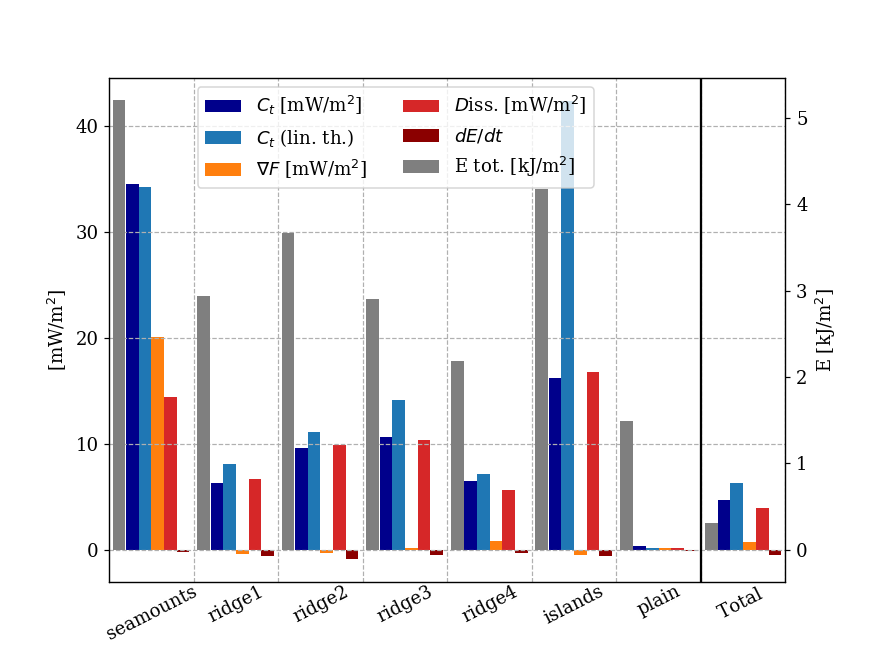

In [98]:
# bar plot for paper

ind = np.arange(len(res)+1)
fields = ['Et_bclin','Cterm','Ctlin','divF_bc','Diss_bc', "dTE"]
cols = ['tab:grey','darkblue','tab:blue','tab:orange','tab:red', "darkred"]
labs = [r'E tot. [kJ/m$^2$]', r"$C_t$ [mW/m$^2$]", r"$C_t$ (lin. th.)", r"$\nabla F$ [mW/m$^2$]", 
        r"$D$iss. [mW/m$^2$]", r"$dE/dt$"]
facts = [1, 1e3, 1e3, 1e3, 1e3, 1e3] # powers of 10 to change units
width = .9

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
bx = ax.twinx()
for ina,nam in enumerate(nams):
    #print(nam)
    ifi, fie = 0, fields[0]
    lab = labs[ifi] if ina==0 else None
    bx.bar(ind[ina]-width/2+width*(ifi+.45)/len(fields), datfra[fie][nam]*facts[ifi], width/len(fields), 
               color=cols[ifi], label=lab)
    for ifi,fie in enumerate(fields[1:]):
        ifi += 1
        lab = labs[ifi] if ina==0 else None
        ax.bar(ind[ina]-width/2+width*(ifi+.5)/len(fields), datfra[fie][nam]*facts[ifi], width/len(fields), 
               color=cols[ifi], label=lab)
        #print(fie, res[nam][fie])
#print("full")
for ifi,fie in enumerate(fields):
    ax.bar(ind[-1]-width/2+width*(ifi+.5)/len(fields), datfra[fie]["full"]*facts[ifi], width/len(fields), 
        color=cols[ifi])
    #print(fie, eval(fie))

ax.set_xlim([-.5,len(nams)+.5])
ax.axvline(len(nams)-.5, color="k")
ax.set_xticks(ind)
ax.set_xticklabels(nams+['Total '], rotation=27, y=.02, ha="center")
ax.set_xticks(ind+.5,minor=True)
ax.grid(which="major", axis="x", linestyle="none")
ax.grid(which="minor", axis="x", linestyle="--")
ax.tick_params(bottom=False, which="both")
ax.grid(axis="y", linestyle="--")
ax.set_ylabel(r'[mW/m$^2$]')
bx.set_ylabel(r'E [kJ/m$^2$]')
limy = ax.get_ylim()
bx.set_ylim(bx.get_ylim()[1]*np.array([limy[0]/limy[1], 1]))
fig.legend(ncol=2, bbox_to_anchor=(.73,1), bbox_transform=ax.transAxes)
#plt.title("NRJ balance per subdomain")

if False: #dosavefig:
    fig.savefig(dirpic+"{}_NRJ_bal_bcl.pdf".format(simul+suff), magnification="auto", bbox_inches="tight")
 

## Snapshots

In [98]:
datfra

,dKE,dPE,hdiff,vmix,drag,KE_bclin,PE_bclin,divF_bc,Cterm,Diss_bc,Ctlin,Et_bclin,dEt
full,0.00325244,0.00108554,0.00194897,0.000268469,0.001035,1.730940,0.815889,0.001090,0.005577,0.004486,0.006314,2.546829,0.00433799
seamounts,0.013867,0.00354191,0.00919045,0.00127304,0.00340352,3.488913,1.994242,0.020402,0.039140,0.018738,0.034230,5.483155,0.0174089
islands,0.0143092,0.00527427,0.00748817,0.00141881,0.00540225,3.101965,1.476532,0.002746,0.020655,0.017930,0.042325,4.578497,0.0195835
ridge1,0.00516298,0.00126002,0.00358591,0.00037204,0.00120503,1.643129,0.933476,0.000315,0.007512,0.007197,0.008098,2.576605,0.006423
ridge2,0.00790172,0.00235309,0.0048576,0.000586827,0.00245729,2.434438,1.176524,-0.000683,0.010810,0.011493,0.011134,3.610963,0.0102548
ridge3,0.00871345,0.00307468,0.00461894,0.000750977,0.00334352,2.469347,1.099741,0.000653,0.012514,0.011864,0.014123,3.569088,0.0117881
ridge4,0.00435961,0.00126485,0.00245535,0.000285498,0.00161876,2.221544,0.849864,0.001377,0.007700,0.006324,0.007173,3.071408,0.00562446


<IPython.core.display.Javascript object>


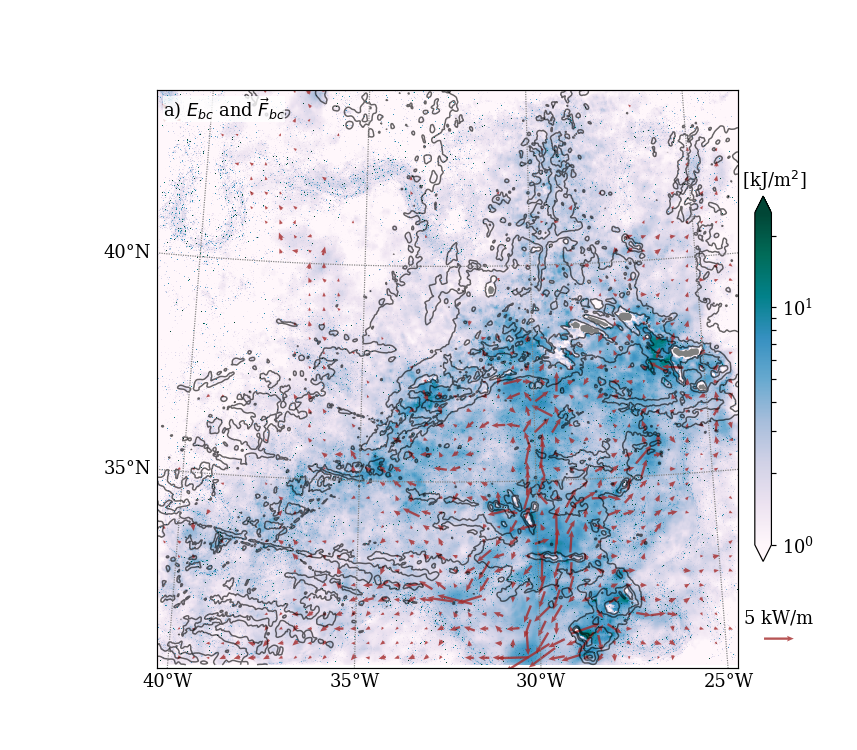

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in less
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


saving in ./pictures/subdom_diags/luckyt_win_etot_avg_log.png


In [51]:
# plot data: ekint + flux
mysc = "log" # "log" # "linear"
cmap = "PuBuGn"
topocol = "k"
usc = 18
usq = 5
nsq = 25
color = "brown"
what = "etot"
do_plotsubdom = False

toplot = eval(what)
    
if mysc == "linear":
    vmin, vmax = 0, ekavg.mean() + 5*ekavg.std() 
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
elif mysc == "log":
    #toplot = np.log10(toplot)
    #vmax = 1 #np.nanmax(np.log10(davg))
    #vmin = 0 #vmax - 1.5
    vmax = 25 #5*np.nanstd(toplot)
    vmin = vmax/25
    norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    
fig = plt.figure(figsize=(8,7))
ax = plt.gca()
bm = Basemap(projection=proj,resolution=brs,lon_0=lon.mean(),\
        lat_0=lat.mean(),width=Lx,height=Ly)
xx, yy = bm(lon, lat)
bm.drawcoastlines(color='gray')
bm.fillcontinents(color='gray')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)
hct = bm.contour(xx,yy,topo,levels=zlevs,colors=topocol,linewidths=1,alpha=0.6)
for item in hct.collections:
    item.set_rasterized(True)

hpc = bm.pcolormesh(xx, yy, toplot, norm=norm, cmap=cmap)
hcb = plt.colorbar(hpc, fraction=.025, extend="both", pad=.025)
#hcb.formatter.set_powerlimits((-1, 1))
#hcb.update_ticks()
hcb.ax.tick_params(labelsize=fs)
#if mysc == "log":
#    bartit = mysc+"({0})    \n[{1}]    ".format(vnam[what],units[what])
#else:
#    bartit = "{0}    \n[{1}]    ".format(vnam[what],units[what])
bartit = "    [{}]".format(units[what])

hcb.ax.set_title(bartit, fontsize=fs, ha="center")

#bm.drawmapscale(lonm.mean() - .8*(lonm.max()-lonm.min())/2, latm.mean() + .9*(latm.max()-latm.min())/2, lonm.mean() \
#                ,latm.mean(), length=200, units="km", style="fancy")

if dostrflu:
    speed = np.sqrt(fxavg**2 + fyavg**2)
    lw = .1 + 4*speed / np.nanmax(speed) # Line Widths
    hqv = bm.streamplot(xx.mean(axis=0), yy.mean(axis=1), fxbc, fybc \
                        , density=5, color=color, linewidth=lw)
elif dosqflu:
    slix, sliy = slice(nsq//2,Nx,nsq), slice(nsq//2,Ny,nsq)
    fxpl, fypl = fxavg[sliy,slix], fyavg[sliy,slix]
    mask = np.sqrt(fxpl**2 + fypl**2)<.5
    hqb = bm.quiver(xx[sliy,slix], yy[sliy,slix], np.ma.masked_where(mask, fxpl) \
                    , np.ma.masked_where(mask, fypl), scale=usc, scale_units="inches" \
              , color='brown', pivot="mid", angles="xy", width=4e-3 \
                    , headlength=3, headwidth=2.5, headaxislength=2.5, alpha=.8)
    hqk = ax.quiverkey(hqb, X=1.07, Y=.05, U=usq \
                       , label=r'{} kW/m'.format(usq))

if do_plotsubdom:
    for key,val in mydoms.items():
        if key == "ridges":
            for dom in val:
                x, y = bm(*np.array(dom).T.take(range(len(dom)+1),axis=1,mode='wrap'))
                bm.plot(x, y, color="darkorange", lw=1)
        else:
            x, y = bm(*np.array(val).T.take(range(len(val)+1),axis=1,mode='wrap'))
            bm.plot(x, y, color="darkorange", lw=1)

    plt.title(simul+": {0} {1}".format(what,str(it)))
ax.text(.01, .99, r'a) $E_{bc}$ and $\vec{F}_{bc}$', transform=ax.transAxes, ha="left", \
        va="top", bbox=dict(facecolor='w', edgecolor='None', pad=.01, alpha=.8))

if dosavefig:
    if tint is not None:
        strit = "{0}-{1}".format(*tint)
    else:
        strit = str(it)
    fname = simul+suff+"_{0}_{1}_{2}.png".format(what,"avg",mysc[:3])
    print("saving in",dirpic+fname)
    fig.savefig(dirpic+fname, magnification='auto' ,dpi=150, bbox_inches="tight")
    

<IPython.core.display.Javascript object>


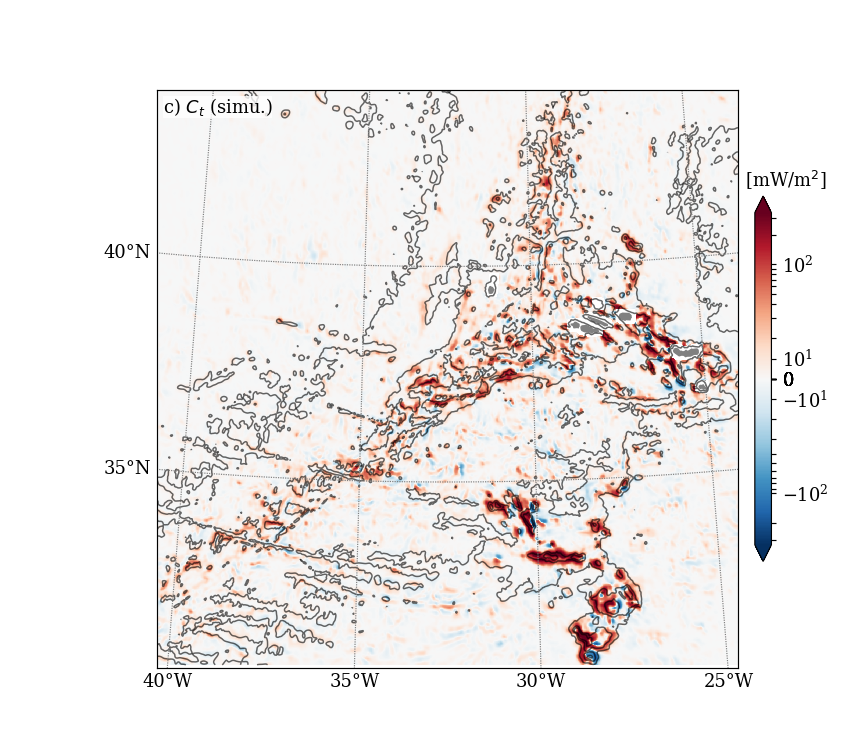

saving in ./pictures/subdom_diags/luckyt_win_ctavg_avg_log.png


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/colors.py:1114: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh


In [53]:
# plot: conversion term, flux divergence, dissipation
mysc = "log" # "log" # "linear"
cmap = "RdBu_r"
topocol = "k"
usq = 5
nsq = 25
color = "olivedrab"
what = "ctavg" #"ctavg" "dfav"
doflux = what in ["divf", "dfav"]
doblur = True
do_plotsubdom = False

title = {"diav":r"e) $D$", "dfav":r"b) $\nabla\cdot\vec{F}_{bc}$ + $\vec{F}_{bc}$", "ctavg":r"c) $C_t$ (simu.)"}
toplot = eval(what) *1e3 # mW/m^2
if doblur:
    toplot = gaussian_filter(toplot, sigma=2, mode="mirror")

if mysc == "lin":
    vmin, vmax = 10*np.nanstd(ctavg) *np.array([-1,1])*1e3
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
elif mysc == "log":
    vamp = 10*np.nanstd(dfav)*1e3
    norm = mpl.colors.SymLogNorm(linthresh=vamp/10, linscale=1, vmin=-vamp, vmax=vamp)
    
fig = plt.figure(figsize=(8,7))
ax = plt.gca()
bm = Basemap(projection=proj,resolution=brs,lon_0=lon.mean(),\
        lat_0=lat.mean(),width=Lx,height=Ly)
xx, yy = bm(lon, lat)
bm.drawcoastlines(color='gray')
bm.fillcontinents(color='gray')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)
hct = bm.contour(xx,yy,topo,levels=zlevs,colors=topocol,linewidths=1,alpha=0.6)
for item in hct.collections:
    item.set_rasterized(True)

hpc = bm.pcolormesh(xx, yy, toplot, norm=norm, cmap=cmap)
hcb = plt.colorbar(hpc, fraction=.025, extend="both", pad=.025)
hcb.ax.tick_params(labelsize=fs)
#if mysc == "log":
#    bartit = mysc+"({0})    \n[{1}]    ".format(vnam[what],units[what])
#else:
#    bartit = "{0}    \n[{1}]    ".format(vnam[what],units[what])
bartit = "\t[{0}]".format(units[what])
hcb.ax.set_title(bartit, fontsize=fs, ha="center")
ax.text(.01, .99, title[what], transform=ax.transAxes, ha="left", \
        va="top", bbox=dict(facecolor='w', edgecolor='None', pad=.01, alpha=.8))

#bm.drawmapscale(lonm.mean() - .8*(lonm.max()-lonm.min())/2, latm.mean() + .9*(latm.max()-latm.min())/2, lonm.mean() \
#                ,latm.mean(), length=200, units="km", style="fancy")

if doflux:
    if True: # dostrflu:
        speed = np.sqrt(fxavg**2 + fyavg**2)
        mask = speed<.5
        lw = 4 * speed / np.nanmax(speed) # Line Widths
        hqv = bm.streamplot(xx.mean(axis=0), yy.mean(axis=1), np.ma.masked_where(mask,fxbc) \
                            , np.ma.masked_where(mask, fybc), density=4, color=color, linewidth=lw)
    elif False:#dosqflu:
        slix, sliy = slice(nsq//2,Nx,nsq), slice(nsq//2,Ny,nsq)
        fxpl, fypl = fxavg[sliy,slix], fyavg[sliy,slix]
        mask = np.sqrt(fxpl**2 + fypl**2)<.5
        hqb = bm.quiver(xx[sliy,slix], yy[sliy,slix], np.ma.masked_where(mask, fxpl) \
                        , np.ma.masked_where(mask, fypl), scale=17, scale_units="inches" \
                  , color='brown', pivot="mid", angles="xy", width=4e-3 \
                        , headlength=3, headwidth=2.5, headaxislength=2.5)
        hqk = ax.quiverkey(hqb, X=1.07, Y=.05, U=usq \
                           , label=r'{} kW/m'.format(usq))
    
if do_plotsubdom:
    for key,val in mydoms.items():
        if key == "ridges":
            for dom in val:
                x, y = bm(*np.array(dom).T.take(range(len(dom)+1),axis=1,mode='wrap'))
                bm.plot(x, y, color="darkorange")
        else:
            x, y = bm(*np.array(val).T.take(range(len(val)+1),axis=1,mode='wrap'))
            bm.plot(x, y, color="darkorange")

    plt.title(simul+": {0} {1}".format(what,str(it)))
    
if dosavefig:
    if tint is not None:
        strit = "{0}-{1}".format(*tint)
    else:
        strit = "avg" #str(it)
    fname = simul+suff+"_{0}_{1}_{2}.png".format(what,strit,mysc[:3])
    print("saving in",dirpic+fname)
    fig.savefig(dirpic+fname, magnification='auto' ,dpi=150, bbox_inches="tight")

<IPython.core.display.Javascript object>


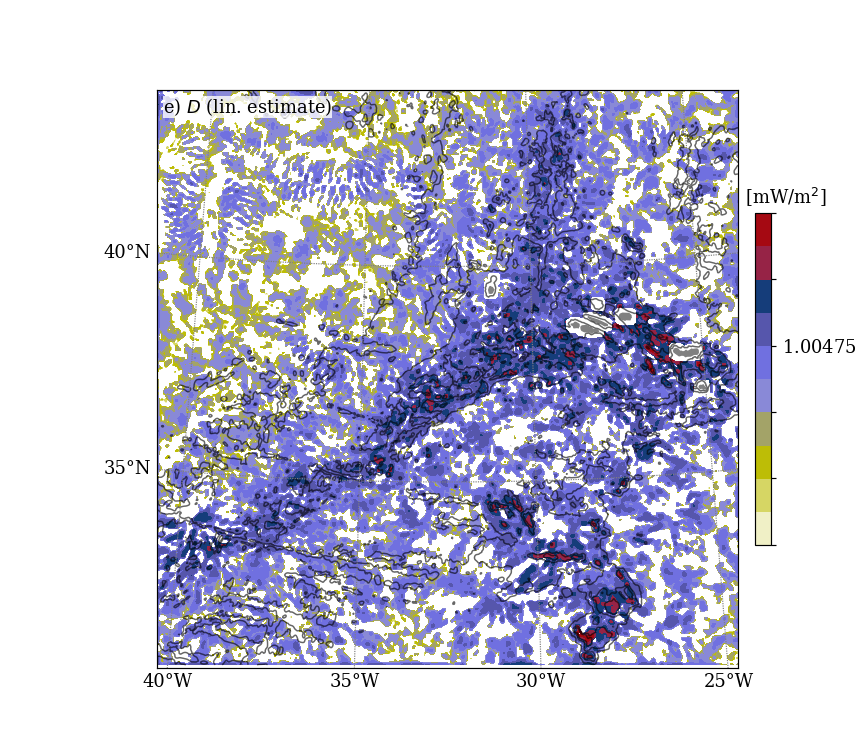

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/contour.py:1536: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


saving in ./pictures/subdom_diags/luckyt_win_diav_avg_PosOnly.png


In [54]:
### dissipation using same colorbar / colormap as diag simu -- logscale only
### can't obtain a good colorbar but I don't really care because I don't need it for the paper

cmap = "gist_stern_r"
topocol = "k"
what = "diav"
doblur = True
do_plotsubdom = False
title = {"diav":r"e) $D$ (lin. estimate)"}
toplot = eval(what)
if doblur:
    toplot = gaussian_filter(toplot, sigma=2, mode="mirror")

valmin = 4e-5
valmax = 0.4
levels = np.logspace(np.log10(valmin),np.log10(valmax),11)    
norm = colors.LogNorm()
    
fig = plt.figure(figsize=(8,7))
ax = plt.gca()
bm = Basemap(projection=proj,resolution=brs,lon_0=lon.mean(),\
        lat_0=lat.mean(),width=Lx,height=Ly)
xx, yy = bm(lon, lat)
bm.drawcoastlines(color='gray')
bm.fillcontinents(color='gray')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)
hct = bm.contour(xx,yy,topo,levels=zlevs,colors=topocol,linewidths=1,alpha=0.6)
for item in hct.collections:
    item.set_rasterized(True)

hpc = bm.contourf(xx, yy, toplot, levels=levels, cmap=cmap, norm=norm)
hcb = plt.colorbar(hpc, fraction=.025, extend="both", pad=.025)
hcb.ax.tick_params(labelsize=fs)
#if mysc == "log":
#    bartit = mysc+"({0})    \n[{1}]    ".format(vnam[what],units[what])
#else:
#    bartit = "{0}    \n[{1}]    ".format(vnam[what],units[what])
bartit = "\t[{0}]".format(units[what])
hcb.ax.set_title(bartit, fontsize=fs, ha="center")
ax.text(.01, .99, title[what], transform=ax.transAxes, ha="left", \
        va="top", bbox=dict(facecolor='w', edgecolor='None', pad=.01, alpha=.8))

#bm.drawmapscale(lonm.mean() - .8*(lonm.max()-lonm.min())/2, latm.mean() + .9*(latm.max()-latm.min())/2, lonm.mean() \
#                ,latm.mean(), length=200, units="km", style="fancy")


if do_plotsubdom:
    for key,val in mydoms.items():
        if key == "ridges":
            for dom in val:
                x, y = bm(*np.array(dom).T.take(range(len(dom)+1),axis=1,mode='wrap'))
                bm.plot(x, y, color="darkorange")
        else:
            x, y = bm(*np.array(val).T.take(range(len(val)+1),axis=1,mode='wrap'))
            bm.plot(x, y, color="darkorange")

    plt.title(simul+": {0} {1}".format(what,str(it)))
    
if dosavefig:
    if tint is not None:
        strit = "{0}-{1}".format(*tint)
    else:
        strit = "avg" #str(it)
    fname = simul+suff+"_{0}_{1}_PosOnly.png".format(what,strit,mysc[:3])
    print("saving in",dirpic+fname)
    fig.savefig(dirpic+fname, magnification='auto' ,dpi=150, bbox_inches="tight")

<IPython.core.display.Javascript object>


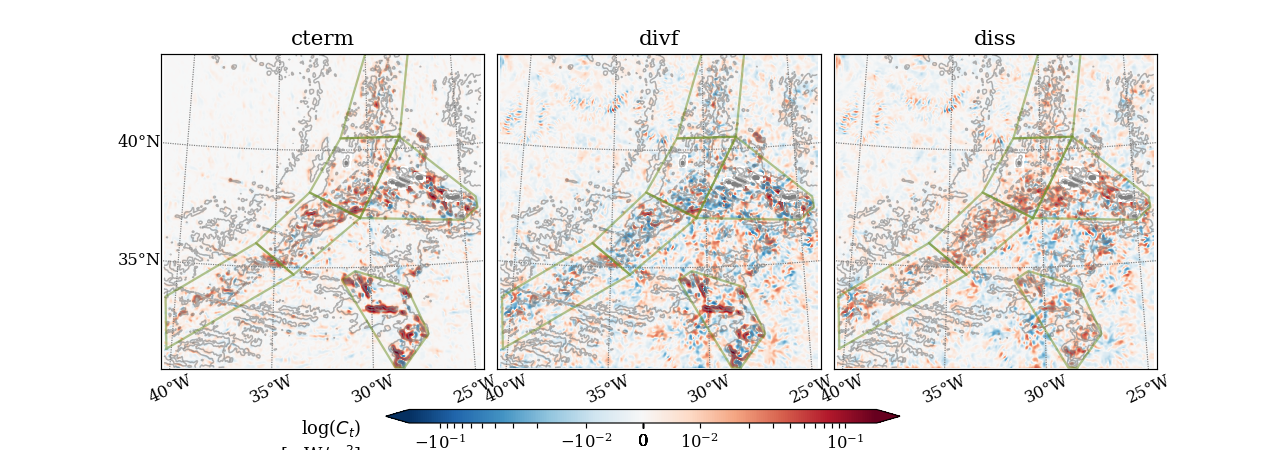

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/colors.py:1114: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh


In [55]:
# conversion, divergence, dissipation
mysc = "log" # "log" # "linear"
cmap = "RdBu_r"
topocol = "grey"
usq = 5
nsq = 25
color = "olivedrab"
what = ["cterm","divf","diss"]
doblur = True

do_plotsubdom = True

if mysc == "lin":
    vmin, vmax = 5*np.nanstd(ctavg) *np.array([-1,1])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
elif mysc == "log":
    vamp = 5*np.nanstd(dfav)
    norm = mpl.colors.SymLogNorm(linthresh=vamp/10, linscale=1, vmin=-vamp, vmax=vamp)
    
fig, axs = plt.subplots(1, len(what), figsize=(len(what)*4,4.2), sharex=True, sharey=True)
for iwa,wha in enumerate(what):
    ax = axs[iwa]
    toplot = eval(wha)
    if doblur:
        toplot = gaussian_filter(toplot, sigma=3, mode="mirror")

    bm = Basemap(projection=proj,resolution=brs,lon_0=lon.mean(),\
            lat_0=lat.mean(),width=Lx,height=Ly, ax=ax)
    xx, yy = bm(lon, lat)
    bm.drawcoastlines(color='gray')
    bm.fillcontinents(color='gray')
    bm.drawparallels(np.arange(-60,70,stride),labels=[int(iwa==0),0,0,0],linewidth=0.8,\
                    fontsize=fs-1,color=grdcol)
    bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                    fontsize=fs-1,color=grdcol, rotation=25)
    hct = bm.contour(xx,yy,topo,levels=zlevs,colors=topocol,linewidths=1,alpha=0.6)
    for item in hct.collections:
        item.set_rasterized(True)

    hpc = bm.pcolormesh(xx, yy, toplot, norm=norm, cmap=cmap)
    ax.set_title(wha)
    
    if do_plotsubdom:
        for key,val in mydoms.items():
            if key == "ridges":
                for dom in val:
                    x, y = bm(*np.array(dom).T.take(range(len(dom)+1),axis=1,mode='wrap'))
                    bm.plot(x, y, color=color, alpha=.5)
            else:
                x, y = bm(*np.array(val).T.take(range(len(val)+1),axis=1,mode='wrap'))
                bm.plot(x, y, color=color, alpha=.5)

fig.subplots_adjust(bottom=0.18, wspace=.04)
cbar_ax = fig.add_axes([0.3, 0.06, 0.4, 0.03])
hcb = fig.colorbar(hpc, cax=cbar_ax, orientation="horizontal", extend="both")
hcb.ax.tick_params(labelsize=fs-1)
if mysc == "log":
    bartit = mysc+"({0})    \n[{1}]    ".format(vnam[what[0]],units[what[0]])
else:
    bartit = "{0}    \n[{1}]    ".format(vnam[what],units[what])
hcb.ax.set_ylabel(bartit, fontsize=fs, ha="right", rotation=0, va="top")

if dosavefig:
    fig.savefig(dirpic+simul+suff+"_{0}_{1}_{2}.png".format("-".join(what),str(it),mysc[:3]), magnification='auto' ,dpi=150, bbox_inches="tight")

## Time evolution
of integrated quantities

In [56]:
# Per subdomain (ct, diss and U_bt only) !
ress = {}

ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
Nt = ncbc.dimensions['time'].size
if 'scrum_time' in ncbc.variables:
    times = ncbc.variables['scrum_time'][:]/24
else:
    times = np.arange(Nt)/24.
prov = (np.gradient(ncbc.variables['puint_lf'][j1:j2,:,:][:,i1:i2,:], axis=1)/dx \
        + np.gradient(ncbc.variables['pvint_lf'][j1:j2,:,:][:,i1:i2,:], axis=0)/dx)*1e3
ncbc.close()

for nam,dom in zip(nams,doms):
    mask = polycoord_tomask(dom, lon, lat) * (topo>100)
    ress[nam] = {"divf":np.nanmean(prov[mask,:], axis=0)}

# conversion and btrop KE
ncbt = MFDataset(fil_sflux, aggdim="eta_rho")
prov = ncbt.variables['Ct_lf'][j1:j2,:,:][:,i1:i2,:]
ncbt.close()
for nam,dom in zip(nams,doms):
    mask = polycoord_tomask(dom, lon, lat) * (topo>100)
    ress[nam]["cterm"] = np.nanmean(prov[mask,:], axis=0)
ncbt = MFDataset(fil_sflux, aggdim="eta_rho")    
prov = np.sqrt(ncbt.variables["ekbt_lf"][j1:j2,:,:][:,i1:i2,:]*2)
ncbt.close()
for nam,dom in zip(nams,doms):
    mask = polycoord_tomask(dom, lon, lat) * (topo>100)
    ress[nam]["Ubt"] = np.nanmean(prov[mask,:], axis=0)

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


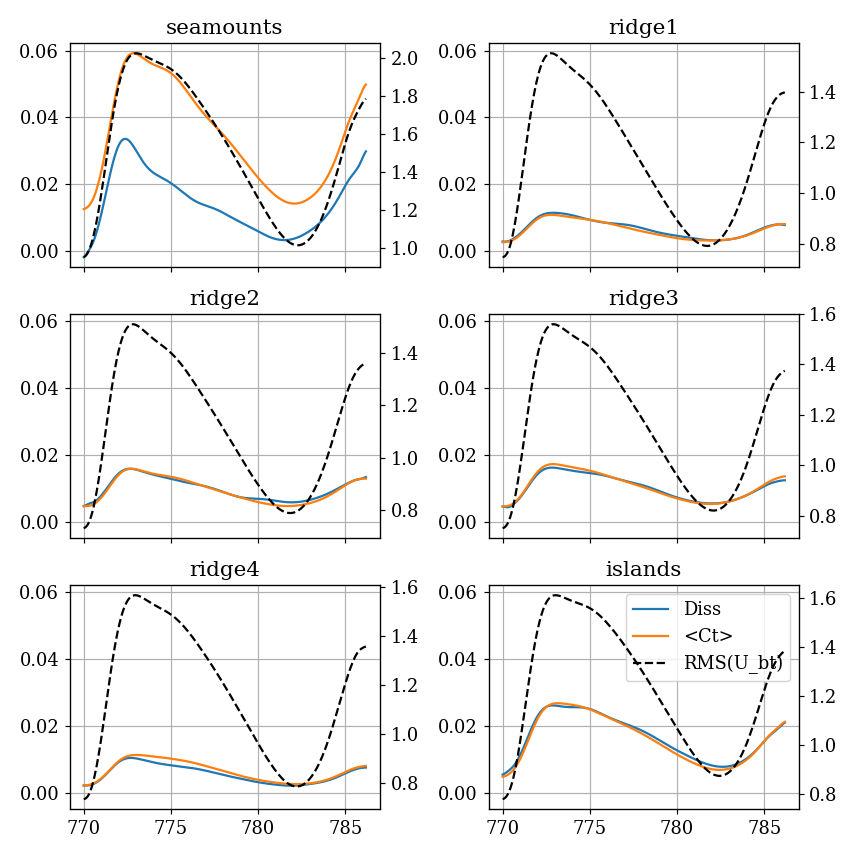

In [59]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(8,8))

# conversion, dissipation
for ia in range(len(doms)):
    ax = axs.ravel()[ia]
    dom, nam = doms[ia], nams[ia]
    ax.plot(times, ress[nam]["cterm"]-ress[nam]["divf"], label="Diss")
    ax.plot(times, ress[nam]["cterm"], label="<Ct>")
    bx = ax.twinx()
    bx.plot(times, ress[nam]["Ubt"], "--k", label="RMS(U_bt)")
    ax.set_title(nam)
for ax in axs.ravel():
    ax.grid(True)
#ax.set_ylabel("Ct and Flux")
#bx.set_ylabel("U_bt")
#ax.set_xlabel('time [day]')

lina, laba = ax.get_legend_handles_labels()
linb, labb = bx.get_legend_handles_labels()
ax.legend(lina+linb, laba+labb, loc="best")

fig.set_tight_layout(True)
#fig.suptitle(simul.upper()+': time series of horizontal mean')


In [60]:
# load data (Integrated NRJ and flux, and generation/divergence/dissipation)

ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
Nt = ncbc.dimensions['time'].size
if 'scrum_time' in ncbc.variables:
    times = ncbc.variables['scrum_time'][:]/24
else:
    times = np.arange(Nt)/24.
    
ekmean = np.nanmean(ncbc.variables['ekint_lf'][j1:j2,:,:][:,i1:i2,:], axis=(0,1))
epmean = np.nanmean(ncbc.variables['epint_lf'][j1:j2,:,:][:,i1:i2,:], axis=(0,1))
flmean = np.nanmean(np.sqrt((ncbc.variables['puint_lf'][j1:j2,:,:][:,i1:i2,:]**2 \
                  + ncbc.variables['pvint_lf'][j1:j2,:,:][:,i1:i2,:]**2)), axis=(0,1))
ncbc.close()

# conversion, div flux and dissipation
# load div flux
ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
Nt = ncbc.dimensions['time'].size
fubc = ncbc.variables['puint_lf'][j1:j2,:,:][:,i1:i2,:]
fvbc = ncbc.variables['pvint_lf'][j1:j2,:,:][:,i1:i2,:]
ncbc.close()
divf = np.nanmean(fubc[:,-1,:] - fubc[:,0,:], axis=0)/Nx/dx + np.nanmean(fvbc[-1,:,:] - fvbc[0,:,:], axis=0)/Ny/dx

# conversion and btrop KE
ncbt = MFDataset(fil_sflux, aggdim="eta_rho")
cterm = np.nanmean(ncbt.variables['Ct_lf'][j1:j2,:,:][:,i1:i2,:], axis=(0,1))
ubt = np.nanmean(np.sqrt(ncbt.variables["ekbt_lf"][j1:j2,:,:][:,i1:i2,:]*2), axis=(0,1))
ekbt = np.nanmean(ncbt.variables["ekbt_lf"][j1:j2,:,:][:,i1:i2,:], axis=(0,1))
epbt = np.nanmean(ncbt.variables["epbt_lf"][j1:j2,:,:][:,i1:i2,:], axis=(0,1))
ncbt.close()

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


<IPython.core.display.Javascript object>


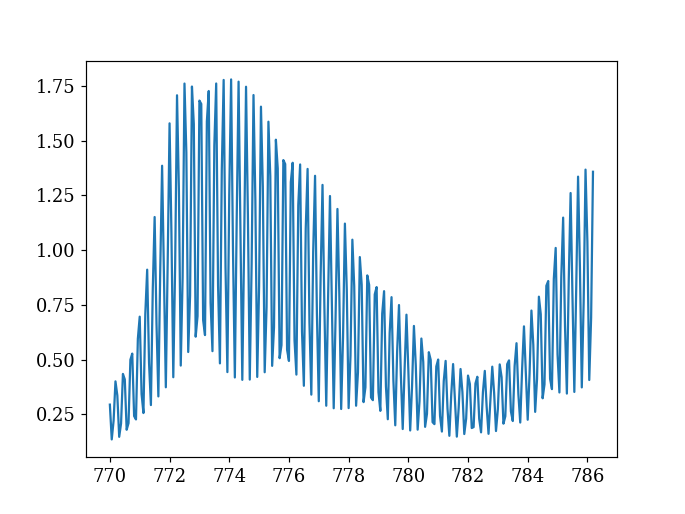

In [61]:
ncbt = MFDataset(fil_sflux, aggdim="eta_rho")
prov = np.nanmean(ncbt.variables["ek_bt"][j1:j2,:,:][:,i1:i2,:], axis=(0,1))
ncbt.close()

plt.figure()
plt.plot(times, prov)

<IPython.core.display.Javascript object>


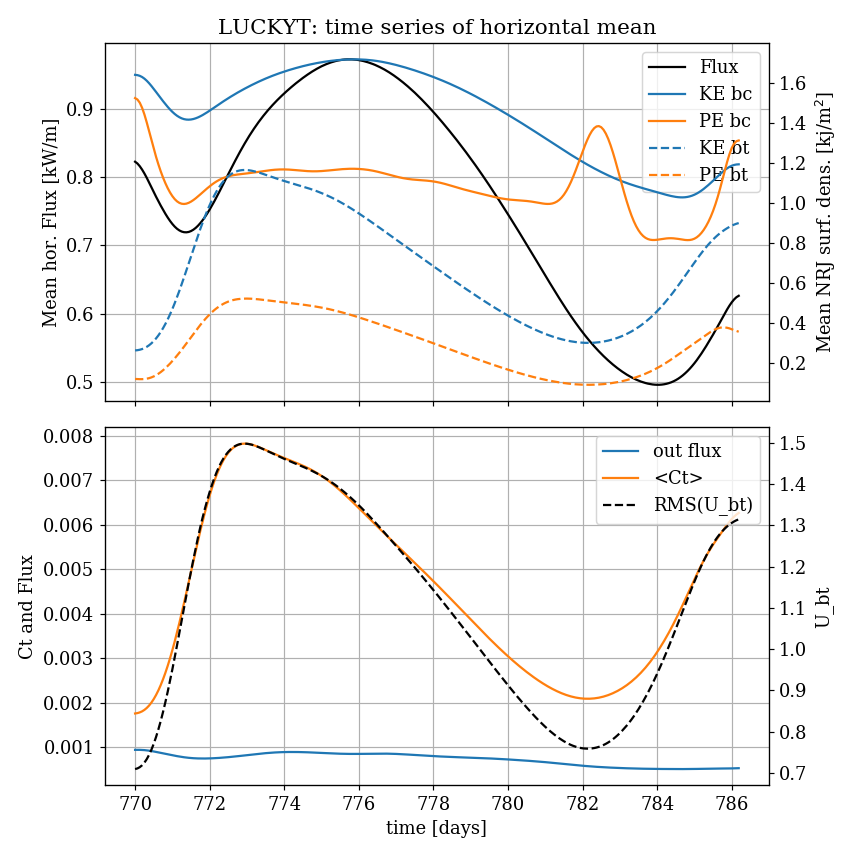

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [62]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8))
# NRJ (and flux) horizontal mean
ax = axs[0]
ax.plot(times, flmean, "k", label="Flux")
ax.set_ylabel(r'Mean hor. Flux [kW/m]')

axb = plt.twinx(ax)
axb.plot(times, ekmean, label="KE bc")
axb.plot(times, epmean, label="PE bc")
axb.plot(times, ekbt, "--", color="C0", label="KE bt")
axb.plot(times, epbt, "--", color="C1", label="PE bt")
axb.set_ylabel(r'Mean NRJ surf. dens. [kj/m$^2$]')

lina, laba = ax.get_legend_handles_labels()
linb, labb = axb.get_legend_handles_labels()
ax.legend(lina+linb, laba+labb, loc="best")

# conversion, dissipation
ax = axs[1]
ax.plot(times, divf*1e3, label="out flux")
ax.plot(times, cterm, label="<Ct>")
bx = ax.twinx()
bx.plot(times, ubt, "--k", label="RMS(U_bt)")
ax.grid(True)
ax.set_ylabel("Ct and Flux")
bx.set_ylabel("U_bt")
ax.set_xlabel('time [day]')

lina, laba = ax.get_legend_handles_labels()
linb, labb = bx.get_legend_handles_labels()
ax.legend(lina+linb, laba+labb, loc="best")

for ax in axs:
    ax.grid(True)
ax.set_xlabel('time [days]')

axs[0].set_title(simul.upper()+': time series of horizontal mean')
fig.set_tight_layout(True)

if dosavefig:
    fig.savefig(dirpic+simul+suff+"_MeanBclinNRJ_tseries.pdf", magnification="auto", bbox_inches="tight")

## mean of summer and winter
I just copy pasted the cells, changing the name of a few variables. It would be smarter to load the dataset directly.

In [99]:
soff = "_win" if suff == "_sum" else "_sum"
fil_iflox = fil_iflux.replace(suff,soff)
fil_sflox = fil_sflux.replace(suff,soff)

In [100]:
suf = "_lf"
it = 200 #182 #436 #182 #    
tint = None #[900, 1019] # put None to take avg as avg // time index

ncbc = Dataset(fil_iflox.replace('?','0'), "r")
times = ncbc.variables['time'][:]
otime = ncbc.variables['scrum_time'][:]
Nt = len(times)
if tint is not None:
    indt, = np.where((times>=tint[0]) & (times<=tint[1]))
else:
    indt = None
    
def get_varavg(nc, var, indt=None, coords=[i1,i2,j1,j2]):
    i1, i2, j1, j2 = coords
    if indt is None:
        return nc.variables[var+"_avg"][j1:j2,...][:,i1:i2,...]
    else:
        return nc.variables[var+"_lf"][j1:j2,...][:,i1:i2,indt].mean(axis=-1)

# load data
print("loading", end="... ")
ncbc = MFDataset(fil_iflox,aggdim='eta_rho')
var = "ekint"
print(var, end=", ")
ekavg = get_varavg(ncbc, var, indt) #ncbc.variables[var+"_avg"][j1:j2,...][:,i1:i2,...]
ekint = ncbc.variables[var+suf][j1:j2,...][:,i1:i2,...][...,it]
var = "epint"
print(var, end=", ")
epavg = get_varavg(ncbc, var, indt) #ncbc.variables[var+"_avg"][j1:j2,...][:,i1:i2,...]
epint = ncbc.variables[var+suf][j1:j2,...][:,i1:i2,...][...,it]
if tint is None:
    ideb, ifin = 0, -1
else:
    ideb = tint[0], tint[-1]
eprov = ncbc.variables["epint"+suf][j1:j2,...][:,i1:i2,...][...,ifin]
ekrov = ncbc.variables["ekint"+suf][j1:j2,...][:,i1:i2,...][...,ifin]
etfin = eprov + ekrov
eprov = ncbc.variables["epint"+suf][j1:j2,...][:,i1:i2,...][...,ideb]
ekrov = ncbc.variables["ekint"+suf][j1:j2,...][:,i1:i2,...][...,ideb]
etdeb = eprov + ekrov
del eprov, ekrov
detot = (etfin - etdeb)/(otime[ifin]-otime[ideb])/3.6 # W/m^2
del etdeb, etfin
    
print("bclin fluxes", end=", ")
fxavg = get_varavg(ncbc, "puint", indt) #ncbc.variables["puint"+"_avg"][j1:j2,...][:,i1:i2,...]
fyavg = get_varavg(ncbc, "pvint", indt) #ncbc.variables["pvint"+"_avg"][j1:j2,...][:,i1:i2,...]
fxbc = ncbc.variables["puint"+suf][j1:j2,...][:,i1:i2,...][...,it]
fybc = ncbc.variables["pvint"+suf][j1:j2,...][:,i1:i2,...][...,it]

ncbc.close()

print("Cterm")
ncbt = MFDataset(fil_sflox,aggdim='eta_rho')
ctavg = get_varavg(ncbt, "Ct", indt) #ncbt.variables["Ct_avg"][j1:j2,...][:,i1:i2,...]
cterm = ncbt.variables["Ct"+suf][j1:j2,...][:,i1:i2,...][...,it]
ncbt.close()

# compute div flux
dfav = (np.gradient(fxavg, axis=1)/dx + np.gradient(fyavg, axis=0)/dx)*1e3
divf = (np.gradient(fxbc, axis=1)/dx + np.gradient(fybc, axis=0)/dx)*1e3

diav = ctavg - dfav
diss = cterm - divf
etot = ekavg + epavg

loading... ekint, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


epint, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


bclin fluxes, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater


Cterm


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


In [101]:
# Apply masks and compute values in subdomains
datfro = pd.DataFrame(index=['full']+nams, \
                          columns=['dKE','dPE','hdiff','vmix','drag'])

# COmpute mean and totals over subdomains. N.B.: not OK for non-uniform grid
ros = {}
for dom,nam in zip(doms,nams):
    mask = polycoord_tomask(dom, lon, lat) * (topo>100)
    siz = ((1/pm/pn)*(mask*1)).sum()
    #print(nam, siz/1e12, end=" ")
    ras = {"size":siz, 'coords':dom}
    ektot = (ekavg/pm/pn)[mask].sum()
    ras["KE_moy"] = np.nanmean((ekavg)[mask])
    ras["KE_tot"] = np.nansum((ekavg/pm/pn)[mask])
    ras["PE_moy"] = np.nanmean((epavg)[mask])
    ras["PE_tot"] = np.nansum((epavg/pm/pn)[mask])
    ras["TE_moy"] = np.nanmean(((ekavg+epavg))[mask])
    ras["TE_tot"] = np.nansum(((ekavg+epavg)/pm/pn)[mask])
    ras["divf_moy"] = np.nanmean((dfav)[mask])
    ras["divf_tot"] = np.nansum((dfav/pm/pn)[mask])
    ras["Ct_moy"] = np.nanmean((ctavg)[mask])
    ras["Ct_tot"] = np.nansum((ctavg/pm/pn)[mask])
    ras["diss_moy"] = np.nanmean((diav)[mask])
    ras["diss_tot"] = np.nansum((diav/pm/pn)[mask])
    ras['dTE_moy'] = np.nanmean((detot)[mask])
    ras["dTE_tot"] = np.nansum((detot/pm/pn)[mask])

    # do the same for the linear estimate (not same resolution, so need to recompute masks)
    mask = polycoord_tomask(dom, lon_lin, lat_lin) * (h_lin>100)
    ras["Ctlin_moy"] = np.nanmean((ct_lin)[mask])
    ras["Ctlin_tot"] = np.nansum((ct_lin*dxlin**2)[mask])
    ros[nam] = ras
TE_moy = np.nanmean(ekavg+epavg)
dTE_moy = np.nanmean(detot)
Ct_moy = np.nanmean(ctavg)
diss_moy = np.nanmean(diav)
divf_moy = np.nanmean(divf)
Ctlin_moy = np.nanmean(ct_lin)

# copy in dataframe
for name,data in zip(["KE_bclin","PE_bclin","dTE","divF_bc","Cterm","Diss_bc","Ctlin"], \
                    [ekavg, epavg, detot, dfav, ctavg, diav, ct_lin]):
    if name in ["Ctlin"]:
        mask = h_lin>100
        domean = lambda x, y: get_domean(x, y, lon=lon_lin, lat=lat_lin, masksup=mask)
    else:
        mask = topo>100
        domean = lambda x, y: get_domean(x, y, lon=lon, lat=lat, masksup=mask)
    datfro[name] = pd.Series(data=[domean(data,dom) for dom in doms],index=nams)
    datfro[name]["full"] = np.nanmean(data[mask])

datfro["Et_bclin"] = datfro["KE_bclin"] + datfro["PE_bclin"]
datfro["dEt"] = datfro["dKE"]+datfro["dPE"]


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


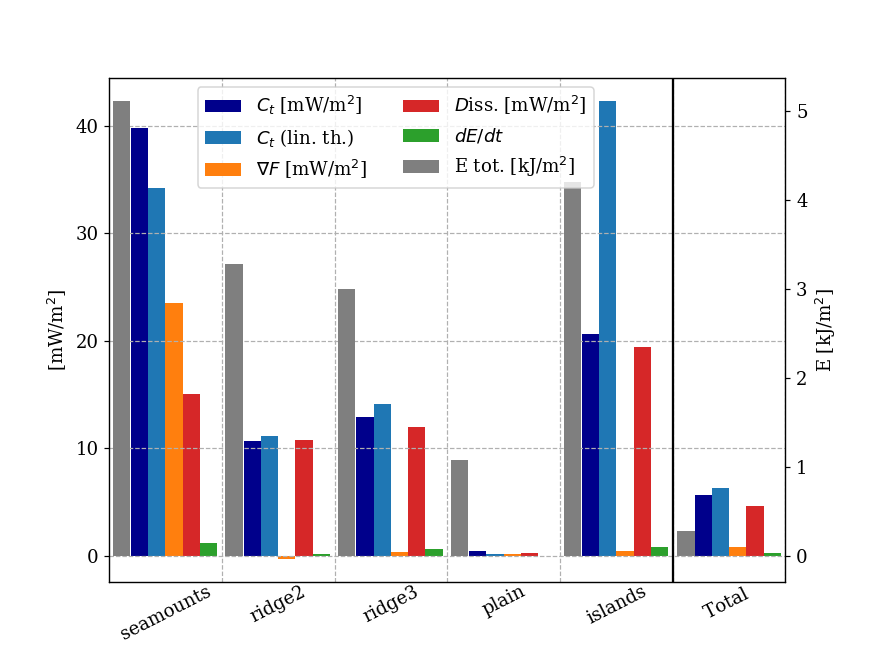

In [104]:
# bar plot for paper

fields = ['Et_bclin','Cterm','Ctlin','divF_bc','Diss_bc', "dTE"]
cols = ['tab:grey','darkblue','tab:blue','tab:orange','tab:red', "tab:green"]
labs = [r'E tot. [kJ/m$^2$]', r"$C_t$ [mW/m$^2$]", r"$C_t$ (lin. th.)", r"$\nabla F$ [mW/m$^2$]", 
        r"$D$iss. [mW/m$^2$]", r"$dE/dt$"]
facts = [1, 1e3, 1e3, 1e3, 1e3, 1e3] # powers of 10 to change units
width = .92

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
bx = ax.twinx()

namplot = ['seamounts', 'ridge2', 'ridge3', 'plain', 'islands']
ind = np.arange(len(namplot)+1)

for ina,nam in enumerate(namplot):
    #print(nam)
    ifi, fie = 0, fields[0]
    lab = labs[ifi] if ina==0 else None
    toplot = (datfra[fie][nam]+datfro[fie][nam])/2.
    bx.bar(ind[ina]-width/2+width*(ifi+.45)/len(fields), toplot*facts[ifi], width/len(fields), 
               color=cols[ifi], label=lab)
    for ifi,fie in enumerate(fields[1:]):
        ifi += 1
        lab = labs[ifi] if ina==0 else None
        toplot = (datfra[fie][nam]+datfro[fie][nam])/2.
        if fie == "Diss_bc":
            toplot -= (datfra["dTE"][nam]+datfro["dTE"][nam])/2.
        ax.bar(ind[ina]-width/2+width*(ifi+.5)/len(fields), toplot*facts[ifi], width/len(fields), 
               color=cols[ifi], label=lab)
        #print(fie, res[nam][fie])
#print("full")
for ifi,fie in enumerate(fields):
    toplot = (datfra[fie]["full"]+datfro[fie]["full"])/2.
    if fie == "Diss_bc":
            toplot -= (datfra["dTE"]["full"]+datfro["dTE"]["full"])/2.
    ax.bar(ind[-1]-width/2+width*(ifi+.5)/len(fields), toplot*facts[ifi], width/len(fields), 
        color=cols[ifi])
    #print(fie, eval(fie))

ax.set_xlim([-.5,len(namplot)+.5])
ax.axvline(len(namplot)-.5, color="k")
ax.set_xticks(ind)
ax.set_xticklabels(namplot+['Total '], rotation=27, y=.02, ha="center")
ax.set_xticks(ind+.5,minor=True)
ax.grid(which="major", axis="x", linestyle="none")
ax.grid(which="minor", axis="x", linestyle="--")
ax.tick_params(bottom=False, which="both")
ax.grid(axis="y", linestyle="--")
ax.set_ylabel(r'[mW/m$^2$]')
bx.set_ylabel(r'E [kJ/m$^2$]')
limy = ax.get_ylim()
bx.set_ylim(bx.get_ylim()[1]*np.array([limy[0]/limy[1], 1]))
fig.legend(ncol=2, bbox_to_anchor=(.73,1), bbox_transform=ax.transAxes)
#plt.title("NRJ balance per subdomain")

if dosavefig:
    fig.savefig("pictures/paper/"+"{}_NRJ_bal_bcl.pdf".format(simul+"-moy"), magnification="auto", bbox_inches="tight")
 

In [81]:
dirpic

'./pictures/subdom_diags/'